# Working with DICOM files in Python

#### Korobov K.S.

In [1]:
import pydicom as pyd
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.filters import threshold_otsu, threshold_local, rank
from skimage.morphology import disk

from skimage import measure, transform, filters, morphology, segmentation, color
import os
from scipy import ndimage
from skimage import io, img_as_float, img_as_ubyte
plt.style.use(["grid", "notebook" ,"dark_background"])

<img title="a title" alt="Z-stack" src="images\Aviation_Cosm_img\z-stack.svg" width="500"/>

In [2]:
# Read multiple dicom files from a directory and return a list of pydicom objects
def read_dicom_files(path):
    dicom_files = []
    for file in os.listdir(path):
        if file.endswith(".dcm"):
            dicom_files.append(pyd.dcmread(os.path.join(path, file)))
    return dicom_files

In [3]:
dicom_dataset = read_dicom_files("DICOM/")

Changin samples per pixel to 1 in DICOM files

In [5]:
for img in dicom_dataset:
    if 'SamplesPerPixel' not in img:
        img.SamplesPerPixel = 1

In [6]:
# Convert the dicom files to numpy arrays
def convert_to_np(dicom_dataset):
    numpy_array = []
    for img in dicom_dataset:
        numpy_array.append(img.pixel_array)
    return np.array(numpy_array)

Creating NumPy data from DICOM files

In [7]:
np_dataset = img_as_ubyte(convert_to_np(dicom_dataset))

Rotating newly created NumPy data

In [8]:
# Taking too long
# np_dataset = transform.rotate(np_dataset, 45, resize=True)

Plotting results

<img title="a title" alt="Z-stack" src="images\Aviation_Cosm_img\int_curve.svg" width="700"/>

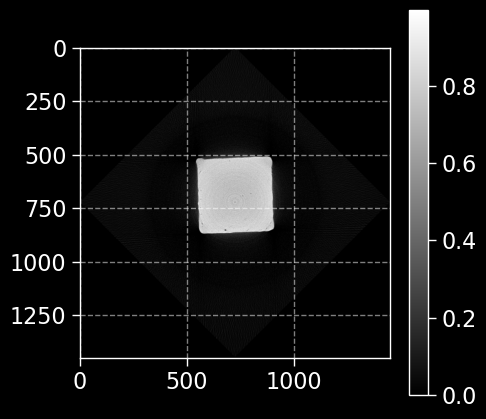

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(transform.rotate(img_as_ubyte(np_dataset[650]), 45, resize=True), cmap="gray")
plt.colorbar()
plt.show()

Using algorithm for one image

In [10]:
img_650 = transform.rotate(img_as_ubyte(np_dataset[650]), 45, resize=True)

In [11]:
# Thresholding img_650
thresh = filters.threshold_minimum(img_650)
binary = img_650 > thresh

In [12]:
# Morphological operations

# Don't need that operations
# binary = morphology.binary_closing(binary, morphology.disk(2))
# binary = morphology.binary_opening(binary, morphology.disk(2))

# Erode
binary = morphology.binary_erosion(binary, morphology.disk(1))

# Labeling the image 
label_img = measure.label(binary)

In [13]:
# Compute the area of each region
regions_nf = measure.regionprops(label_img)
max_area_nf = max([region.area for region in regions_nf])
min_area_nf = min([region.area for region in regions_nf])

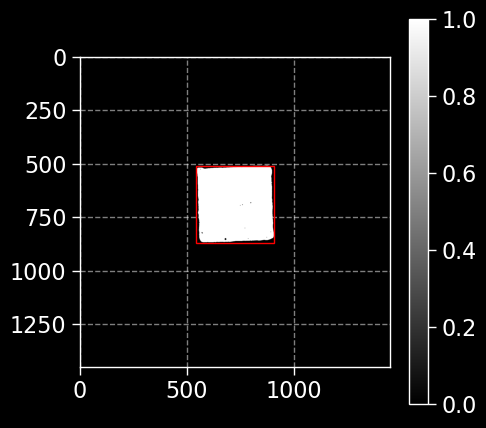

In [14]:
# Plot the labeled image and bbox of the largest region
plt.figure(figsize=(5,5))
plt.imshow(label_img, cmap="gray")
for region in regions_nf:
    if region.area == max_area_nf:
        minr, minc, maxr, maxc = region.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, edgecolor="r", facecolor="none")
        plt.gca().add_patch(rect)
plt.colorbar()
plt.show()

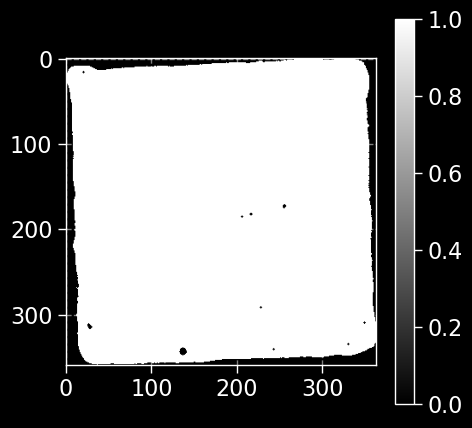

In [15]:
# Crop label_img to the bounding box of the largest region
img_650_cropped = label_img[minr:maxr, minc:maxc]

# Final img_650_nf
img_650_nf = img_650_cropped

# Plot the cropped image
plt.figure(figsize=(5,5))
plt.imshow(img_650_cropped, cmap="gray")
plt.colorbar()
plt.show()

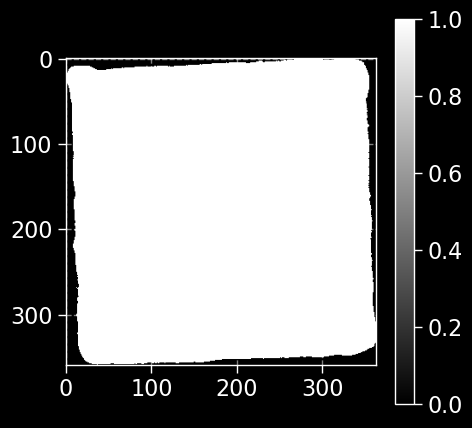

In [16]:
# Cropped binary image
binary_cropped = img_650_cropped > thresh

# Use ndimage to fill the holes in the image
img_650_f = ndimage.binary_fill_holes(binary_cropped)


# Compute the area of each region
regions_f = measure.regionprops(img_as_ubyte(img_650_f))
max_area_f = max([region.area for region in regions_f])

# Plot the labeled image using color.lab2rgb
plt.figure(figsize=(5,5))
plt.imshow(img_650_f, cmap="gray")
plt.colorbar()
plt.show()

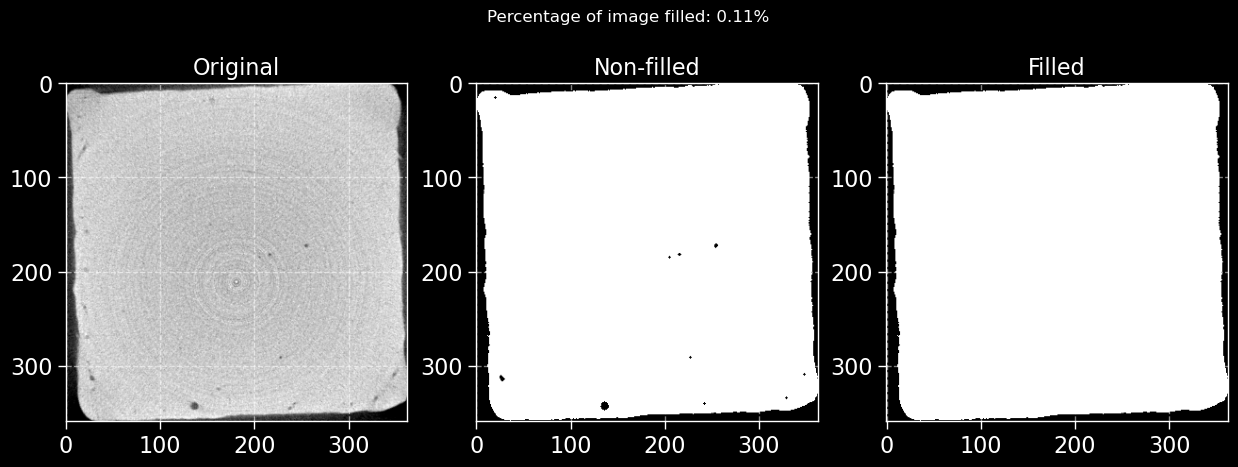

In [17]:
# Plot img_650_nf and img_650_f and original image side by side.
# Create text which shows (1 - max_area_nf/max_area_f) * 100
# as the percentage of the image that was filled
# Left only 2 decimal places

decimal_places = 2

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_650[minr:maxr, minc:maxc], cmap="gray")
plt.title("Original")
plt.suptitle("Percentage of image filled: " + str(round((1 - max_area_nf/max_area_f) * 100, decimal_places)) + "%")
plt.subplot(1,3,2)
plt.imshow(img_650_nf, cmap="gray")
plt.title("Non-filled")
plt.subplot(1,3,3)
plt.imshow(img_650_f, cmap="gray")
plt.title("Filled")
plt.show()

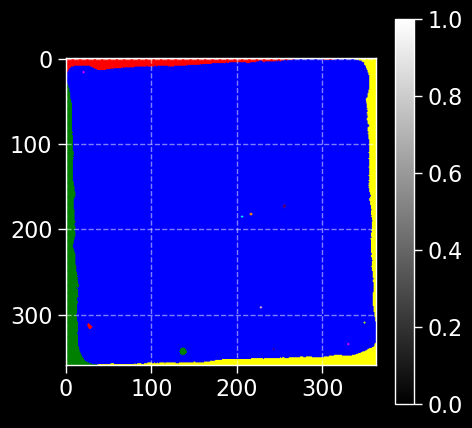

In [18]:
# Remove largest region from ~img_650_nf
# Compute the area of each region
img_pors_650_nf = ~img_650_nf

# Label the image
label_img_pors_650_nf = measure.label(img_pors_650_nf)

# Plot label_img_pors_650_nf using color.label2rgb
plt.figure(figsize=(5,5))
plt.imshow(color.label2rgb(label_img_pors_650_nf, bg_label=0), cmap="gray")
plt.colorbar()
plt.show()

In [19]:
# Remove 5 largest regions from label_img_pors_650_nf
# Compute the area of each region
regions_pors_650_nf = measure.regionprops(label_img_pors_650_nf)
max_areas_pors_650_nf = sorted([region.area for\
    region in regions_pors_650_nf], reverse=True)[:5]

# Loop through the regions and remove the 5 largest regions
for region in regions_pors_650_nf:
    if region.area in max_areas_pors_650_nf:
        for coord in region.coords:
            label_img_pors_650_nf[coord[0], coord[1]] = 0

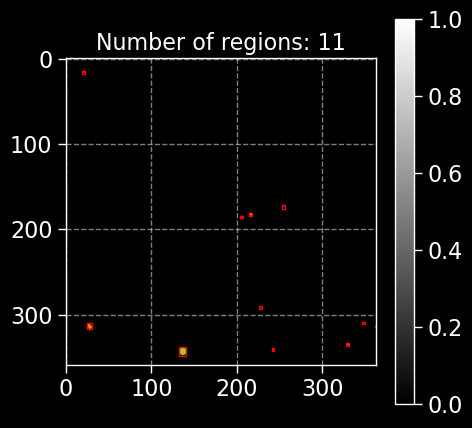

In [20]:
# Plot label_img_pors_650_nf using color.label2rgb.
# Put number of regions in the title
# Create bbox around each region

plt.figure(figsize=(5,5))
plt.imshow(color.label2rgb(label_img_pors_650_nf, bg_label=0), cmap="gray")
plt.title("Number of regions: " + str(len(measure.regionprops(label_img_pors_650_nf))))
for region in measure.regionprops(label_img_pors_650_nf):
    minr, minc, maxr, maxc = region.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, edgecolor="r", facecolor="none")
    plt.gca().add_patch(rect)
plt.colorbar()
plt.show()

Create STL file from pores data

In [ ]:
# import trimesh

In [ ]:
# Create STL file from label_img_pors_650_nf using marching cubes algorithm and save it
# verts, faces, normals, values = measure.marching_cubes(label_img_pors_650_nf, 0)
# mesh = trimesh.Trimesh(vertices=verts, faces=faces)
# mesh.export("mesh.stl")